In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from HelperFunctions import *
from PtOccupancyFunctions import *
import scipy.integrate
import pprint
from FindDataFunctions import *
from pprint import pprint
from IPython.core.display import display, HTML
from matplotlib import cm

In [32]:
# path = "/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/bimodal/output/VaryDCutLogNonLocTT5Alpha/"
# path = "/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/bimodal/output/VaryEllDCutConstDrt1000Drt3000Mean3Alpha900Beta/"
# path = "/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/bimodal/output/VaryEllDCutConstDrt1000Drt3000Mean3Alpha900Beta/"
path = "/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/bimodal/output/3Alpha1200Beta/"

In [33]:
# dcut_dirs = getBimDirsVaryDCut(path, 100)
# uni_dirs = getUniDirs(path, 100)
# car_dir = getCarDir(path)

# pprint.pprint(dcut_dirs)
# print('\n---\n')
# pprint.pprint(uni_dirs)
# print('\n---\n')
# pprint.pprint(car_dir)
# n_sims = len(dcut_dirs)# - 1

In [34]:
keys = ["drt", "dcut", "l"]
values = ["100", None, None]

def readData(nReqs):
    load_path = os.path.join(path, str(nReqs)+"reqs")
#     uni_dirs = getUniDirs(load_path, 100)

    saved_path = os.path.join(load_path, "saved.pkl")
    saved_path_car = os.path.join(load_path, "saved_car.pkl")
    # Load car dataframe
    if os.path.isfile(saved_path_car):
        df_car = pd.read_pickle(saved_path_car)
    else:
#         car_dir = getCarDir(load_path)
#         df_car = getTrips(car_dir, "car")
#         df_car.to_pickle(saved_path_car)
        df_car = -1
    
    # Load bimodal dataframe
    if os.path.isfile(saved_path):
        df = pd.read_pickle(saved_path)
    else:
#         dcut_dirs = getBimDirsVaryDCut(load_path, 1000)
        dcut_dirs = getDirs(load_path, keys, values)
        cols = ["dcut", "l", "occupancy", "detour", "servability", "req_mean_dist", "drt_travel_time_normalized",
                "drt_wait_time_normalized", "drt_distance", "cummulative_dist_drt",
                "cummulative_dist_drt_unshared", "pkm_drt"]
        df = pd.DataFrame(np.full((len(dcut_dirs),len(cols)), np.nan), columns=cols)
        for i,e in enumerate(dcut_dirs):
            row = df.iloc[i,:]
            try:
                row.loc["dcut"] = float(e[1])
                row.loc["l"] = float(e[2])
                dic = e[3]
                row.loc["occupancy"], _ = getDrtOccupandyAndStandingFrac(dic, False, False)
                df_detour = getDrtDetours(dic)
                row.loc["detour"] = df_detour["distanceDetour"].mean()
                trip_succ = getTripSuccess(dic)
                row.loc["servability"] = len(trip_succ[trip_succ["tripSuccess"]]) / len(trip_succ)
                df_persons = getPersons(dic)
                row.loc["req_mean_dist"] = df_persons["mean_dist"].mean()
                drt_trips, drt_trips_perperson = getDrtTrips(dic)
                row.loc["cummulative_dist_drt"] = getDrtVehicleDistances(dic).sum()
                row.loc["cummulative_dist_drt_unshared"] = drt_trips["direcTravelDistance_m"].sum()
                df_detour = df_detour.set_index("person")
                row.loc["drt_wait_time_normalized"] = (drt_trips_perperson["waitTime"]/df_detour["unsharedTime"]).mean()
                row.loc["drt_travel_time_normalized"] = (drt_trips_perperson["travelTime"]/df_detour["unsharedTime"]).mean()
                row.loc["drt_distance"] = drt_trips_perperson["travelDistance_m"].mean()
                _, row.loc["pkm_drt"] = getModeStats(dic, [], ["drt"])
            except KeyError:
                print("KeyError")
                pass

            print("-----")

        df.to_pickle(saved_path)

    
    df = df.sort_values(["dcut", "l"])
#     display(df["l"])
#     display(df["dcut"])
    df["l"] /= df["req_mean_dist"].mean()
    df["dcut"] /= df["req_mean_dist"].mean()
#     data = np.einsum("ijk->jik", data)
    
    return df, df_car

---
# Visualization

In [35]:
# dcuts, ells, data = readData(10000)
df, df_car = readData(10000)
df["efficiency"] = df["occupancy"]/df["detour"]

In [36]:
print(str(df["req_mean_dist"].mean()) + " should be a lot larger than " + str(df["req_mean_dist"].std()))

1477.3330607858668 should be a lot larger than 2.275557929537614e-13


In [37]:
mean_dist = 3000
beta = 1/6*(np.sqrt(2)+np.log(1+np.sqrt(2)))

def inverseGammaDistUnnormalized(x, d_mean=mean_dist, k=3.1):
    if (x==0):
        return 0
    elif (x>50000):
        return 0
    else:
        z = x/d_mean
        return (z**(-k))*np.exp(-(k-2)/z)

normalization_inverse_gamma = scipy.integrate.quad(inverseGammaDistUnnormalized,0,np.infty)[0]

print("Normalization factor for InverseGamma distribution: ", normalization_inverse_gamma)

def inverseGammaDist_(x):
    return inverseGammaDistUnnormalized(x)/normalization_inverse_gamma

rpr_ = lambda x: x*inverseGammaDist_(x)

def getBimFrac_(dcut):
    return scipy.integrate.quad(inverseGammaDist, dcut, np.infty)[0]

def getBimFracAvDist_(ell, dcut):
    return getBimFrac_(dcut)*2*beta*ell

def getUniFrac_(dcut):
    return 1 - getBim_Frac_(dcut)

def getUniFracAvDist_(dcut):
    return scipy.integrate.quad(rpr_, 0, dcut)[0]

rpr = np.vectorize(rpr_)
inverseGammaDist = np.vectorize(inverseGammaDist_)
getBimFrac = np.vectorize(getBimFrac_)
getUniFrac = np.vectorize(getUniFrac_)
getBimFracAvDist = np.vectorize(getBimFracAvDist_)
getUniFracAvDist = np.vectorize(getUniFracAvDist_)

Normalization factor for InverseGamma distribution:  2566.2689848450755


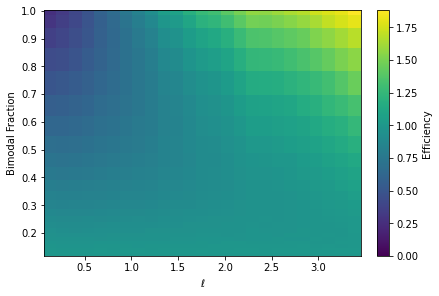

In [48]:
%matplotlib inline
# data_ = np.einsum("ijk->jik", data)
fig, ax = plt.subplots(constrained_layout=True)

# df_mod = df[df["l"] < 1000]
# df_mod = df_mod[df_mod["dcut"] < 10000]
df_mod = df
data = df_mod.pivot(index="l", columns="dcut", values=["efficiency", "servability", "drt_travel_time_normalized",
                                                       "drt_wait_time_normalized" ,"drt_distance",
                                                       "req_mean_dist", "cummulative_dist_drt",
                                                      "cummulative_dist_drt_unshared", "pkm_drt",
                                                       "occupancy", "detour"])
Z = data["cummulative_dist_drt_unshared"]/data["cummulative_dist_drt"]
# Z = data["occupancy"]/data["detour"]
# Z = data["pkm_drt"]
y = getBimFrac(Z.columns.to_numpy()*df["req_mean_dist"].mean())
# y = Z.columns.to_numpy()
X,Y = np.meshgrid(Z.index.to_numpy(), y, indexing='ij')
# X,Y = np.meshgrid(Z.index.to_numpy(), bimodalFrac, indexing='ij')

im = ax.pcolor(X,Y,Z.to_numpy(), shading='auto', linewidth=0, vmin=0)
im.set_edgecolor('face')
# ax = sns.heatmap(data[:,:,0])
# plt.colorbar(im, label=r"$\langle b\rangle/\langle\delta\rangle$")
plt.colorbar(im, label="Efficiency")
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel(r"$\ell$")
# ax.set_ylabel(r"$d_\mathrm{cut}$")
ax.set_ylabel("Bimodal Fraction")

# fig.savefig("figures/EfficiencyConstDrtDemand3Alpha900Beta.jpg", dpi=200)
plt.show()

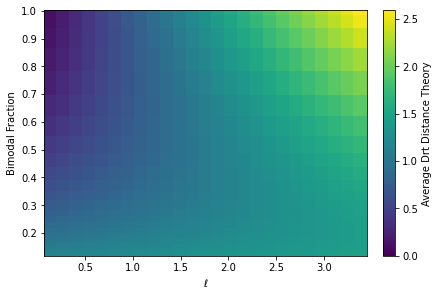

In [49]:
fig, ax = plt.subplots(constrained_layout=True)

ELL, DCUT = np.meshgrid(Z.index.to_numpy()*df["req_mean_dist"].mean(), Z.columns.to_numpy()*df["req_mean_dist"].mean(), indexing='ij')
avDist = (getBimFracAvDist(ELL,DCUT) + getUniFracAvDist(DCUT))/df["req_mean_dist"].mean()
y = getBimFrac(Z.columns.to_numpy()*df["req_mean_dist"].mean())
X, Y = np.meshgrid(Z.index.to_numpy(), y, indexing='ij')

im = ax.pcolor(X,Y,avDist, shading='auto', linewidth=0, vmin=0)
plt.colorbar(im, label="Average Drt Distance Theory")

ax.set_xlabel(r"$\ell$")
ax.set_ylabel("Bimodal Fraction")

# fig.savefig("figures/AvDrtDistConstDrtDemand3Alpha900Beta.jpg", dpi=200)

plt.show()

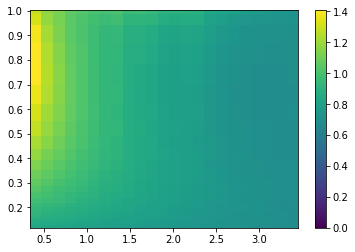

In [52]:
%matplotlib inline
fig, ax = plt.subplots()

plot_range = np.s_[2:,:]
im = ax.pcolor(X[plot_range],Y[plot_range],Z.to_numpy()[plot_range]/avDist[plot_range], shading='auto', linewidth=0, vmin=0)

plt.colorbar(im)
plt.show()

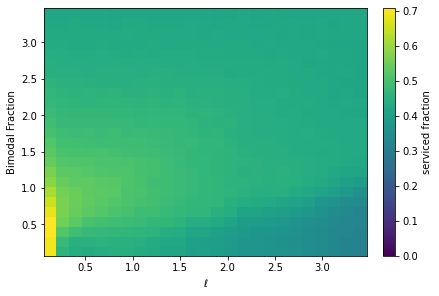

In [49]:
fig, ax = plt.subplots(constrained_layout=True)

im = ax.pcolor(X,Y,data["servability"].to_numpy(), shading='auto', vmin=0)#, vmax=1, linewidth=0)
im.set_edgecolor('face')
# ax = sns.heatmap(data[:,:,0])
plt.colorbar(im, label="serviced fraction", )
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel(r"$\ell$")
# ax.set_ylabel(r"$d_\mathrm{cut}$")
ax.set_ylabel("Bimodal Fraction")

# fig.savefig("figures/ServabilityConstDrtDemand3Alpha900Beta.png", dpi=200)
plt.show()

In [57]:
k=3.1
def inverseGammaDistUnnormalized(x, k=3.1, mean_distance=1):
    return (x**(-k))*np.exp(-(k-2)*mean_distance/x)

normalization_inverse_gamma_analytical = (k-2)**(k-1)/scipy.special.gamma(k-1)

def inverseGammaDist(x):
    return inverseGammaDistUnnormalized(x)*normalization_inverse_gamma_analytical

p = inverseGammaDist
rpr = lambda r: r*p(r)
cummulative_prob = lambda x: scipy.integrate.quad(p,0,x)[0]

def getEmissions_(ell, dcut, eta, eps0p):
#     dcut = 2*beta/(1-4*eta*eps0p/np.pi)*ell
    av_d = scipy.integrate.quad(rpr,0,np.infty)[0]
    E_drt = 1/eta*(scipy.integrate.quad(rpr,0,dcut)[0] + 2*beta*ell*(1-cummulative_prob(dcut)))/av_d
    E_pt = 4*eps0p/(np.pi*av_d)*scipy.integrate.quad(rpr, dcut, np.infty)[0]

    E = E_drt + E_pt
    return E

def getQuality_(ell, dcut, delta, kappa):
    v_ratio = 1/2
    av_d = scipy.integrate.quad(rpr,0,np.infty)[0]

    rt1 = delta*scipy.integrate.quad(rpr,0,dcut)[0]/av_d
    rt2 = (np.pi*kappa/(scipy.integrate.quad(rpr,dcut,np.infty)[0]*ell/av_d) + 2*beta*ell)*(1-cummulative_prob(dcut))
    rt3 = 4*v_ratio*scipy.integrate.quad(rpr,dcut,np.infty)[0]/(np.pi*av_d)
    return 1/(rt1+rt2+rt3)

getEmissions = np.vectorize(getEmissions_)
getQuality = np.vectorize(getQuality_)

In [77]:
bs = []
deltas = []
bs.append(1.5)
bs.append(data["occupancy"])
deltas.append(1.3)
deltas.append(data["detour"])
epsp = 0.2
kappas = [0.001, 0.01, 0.1, 0.5, 1, 10]
# kappas = [0.01, 10]

perf_list = []
pare_list = []

for b,delta in zip(bs, deltas):
    eta = b / delta
    for j,kappa in enumerate(kappas):
        Emissions = getEmissions(X, Y, eta, epsp).flatten()
        Quality = getQuality(X, Y, delta, kappa).flatten()

        pareto_eff = isParetoEfficient(np.stack((-Quality, Emissions), axis=1))

        perf_list.append(np.stack((Quality, Emissions), axis=1))
        pare_list.append(pareto_eff)

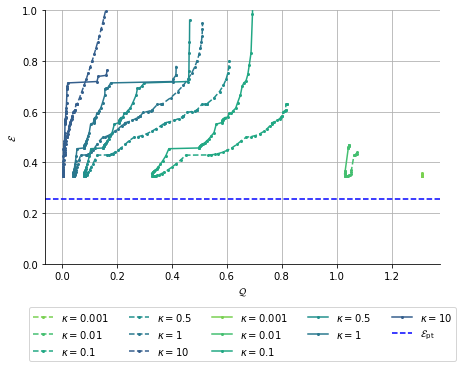

In [86]:
def getC(x):
    a = 0.2
    b = 0.8
    viridisr = cm.get_cmap("viridis_r")
    return viridisr(x*(b-a)+a)

fig, ax = plt.subplots(constrained_layout=True, figsize=(6.4, 5.))

styles = ["--o", "-o"]
# styles = ["-o"]

for i,ls in enumerate(styles):
    for j,kappa in enumerate(kappas):
        idx = i*len(kappas)+j
        Quality = perf_list[idx][:,0]
        Emissions = perf_list[idx][:,1]
        pareto_eff = pare_list[idx]

        Q_pareto = Quality[pareto_eff]
        sorted_idx = np.argsort(Q_pareto)
        Q_pareto = Q_pareto[sorted_idx]
        E_pareto = Emissions[pareto_eff][sorted_idx]

        ax.plot(Q_pareto, E_pareto, ls, color=getC(j/len(kappas)), ms=2, label=rf"$\kappa = {kappa}$")
    
ax.grid()
# ax.axvline(1/delta, ls="--", color="orange", label="$\mathcal{Q}_\mathrm{uni}$")
# ax.axhline(1/eta, ls="--", color="orange", label="$\mathcal{E}_\mathrm{uni}$")
# ax.scatter(1/delta, 1/eta, color="orange")
ax.axhline(4*epsp/np.pi, ls="--", color="blue", label="$\mathcal{E}_\mathrm{pt}$")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0,1)
ax.set_xlabel("$\mathcal{Q}$")
ax.set_ylabel("$\mathcal{E}$")
ax.legend(loc="upper center", bbox_to_anchor=(0.5,-0.15), ncol=5)

# fig.savefig("Figures/TheoryParetos25e2Points.pgf")

plt.show()

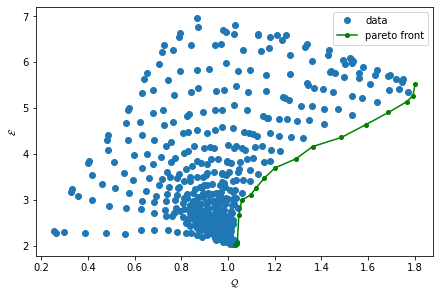

In [10]:
fig, ax = plt.subplots(constrained_layout=True)

data = df.pivot(index="l", columns="dcut", values=["efficiency", "servability", "drt_travel_time_normalized",
                                                       "drt_wait_time_normalized" ,"drt_distance",
                                                       "req_mean_dist", "cummulative_dist_drt",
                                                      "cummulative_dist_drt_unshared", "pkm_drt",
                                                       "occupancy", "detour"])

efficiencies = data["efficiency"].to_numpy().flatten()
qualities = data["drt_travel_time_normalized"].to_numpy().flatten()
costs = np.stack((-efficiencies, qualities), axis=1)

pareto_efficient = isParetoEfficient(costs)
pareto_efficiencies = efficiencies[pareto_efficient]
pareto_qualities = qualities[pareto_efficient]
sorted_idx = np.argsort(pareto_efficiencies)

ax.plot(qualities[~pareto_efficient], efficiencies[~pareto_efficient], "o", label="data")
ax.plot(pareto_qualities[sorted_idx], pareto_efficiencies[sorted_idx], "-o", c="green", ms=4, label="pareto front")
# ax.plot(efficiencies[~pareto_efficient], qualities[~pareto_efficient], "o", label="data")
# ax.plot(pareto_efficiencies[sorted_idx], pareto_qualities[sorted_idx], "-o", c="green", ms=4, label="pareto front")
ax.set_xlabel(r"$\mathcal{Q}$")
ax.set_ylabel(r"$\mathcal{E}$")
ax.legend()

# fig.savefig("figures/DrtPartParetoFront.png", dpi=200)
plt.show()

In [37]:
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

display(pareto_efficient.reshape(data["efficiency"].to_numpy().shape))

array([[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,  True, False],
       [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,  True, False],
       [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False, False, Fa

In [38]:
display(data["efficiency"])

dcut,0.135379,0.270758,0.406137,0.541516,0.676895,0.812275,0.947654,1.083033,1.218412,1.353791,...,2.166065,2.301444,2.436824,2.572203,2.707582,2.842961,2.978340,3.113719,3.249098,3.384477
l,,,,,,,,,,,,,,,,,,,,,
0.135379,0.252537,0.260511,0.297067,0.384877,0.474947,0.559294,0.626417,0.681216,0.741651,0.779402,...,0.942987,0.947621,0.955694,0.960229,0.978542,1.009366,1.004724,1.007429,1.029710,1.019409
0.270758,0.330399,0.328311,0.356032,0.418344,0.490428,0.564152,0.625156,0.682168,0.734530,0.758912,...,0.925891,0.940483,0.955817,0.963903,0.987415,0.989720,1.000444,1.016862,1.022690,1.019409
0.406137,0.402353,0.400075,0.414810,0.461324,0.516066,0.575706,0.632535,0.680847,0.728415,0.768596,...,0.923483,0.937397,0.944445,0.962873,0.981682,0.992797,1.002034,1.010420,1.026054,1.019409
0.541516,0.485221,0.483264,0.486783,0.512000,0.552781,0.594048,0.648109,0.690803,0.735254,0.775171,...,0.918281,0.933916,0.945305,0.950825,0.968172,0.985618,0.985288,1.009067,1.032758,1.019409
0.676895,0.576909,0.570244,0.563812,0.572713,0.595193,0.629958,0.662012,0.702776,0.739304,0.771684,...,0.924560,0.935734,0.938629,0.963005,0.965831,0.986743,1.004503,1.010075,1.027402,1.019409
0.812275,0.652551,0.640129,0.632739,0.622163,0.630752,0.651449,0.680177,0.717619,0.747521,0.779337,...,0.921809,0.919223,0.940495,0.962598,0.969100,0.972068,1.001858,1.013715,1.028284,1.019409
0.947654,0.727243,0.717689,0.703149,0.680418,0.680308,0.683763,0.712294,0.737759,0.750288,0.783773,...,0.920227,0.925783,0.946111,0.955636,0.956588,0.991640,1.004643,1.006691,1.031151,1.019409
1.083033,0.792216,0.791105,0.762619,0.743328,0.723350,0.726032,0.733013,0.755789,0.781040,0.788955,...,0.915820,0.923711,0.937181,0.960890,0.967336,0.993111,0.986060,1.019539,1.039746,1.019409
1.218412,0.866555,0.873319,0.840046,0.793240,0.768761,0.762649,0.754448,0.770888,0.789007,0.809477,...,0.915553,0.924774,0.955839,0.962960,0.969915,0.987150,0.992853,0.996352,1.023164,1.019409


---

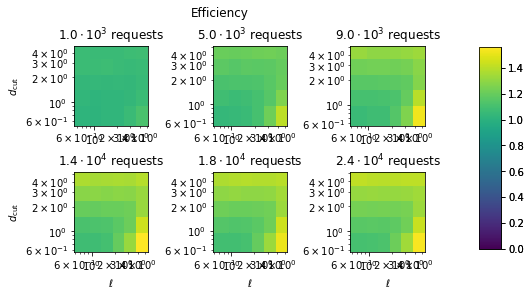

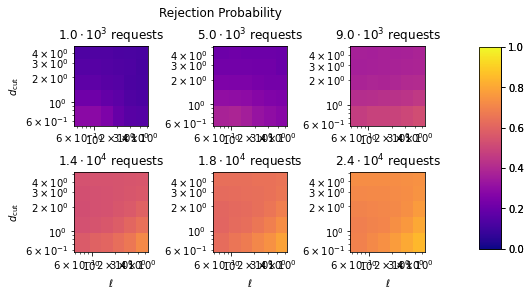

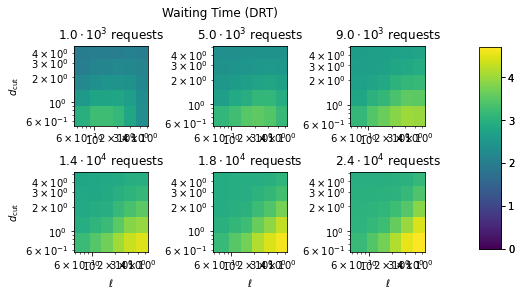

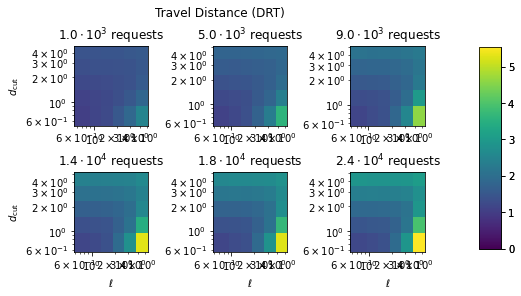

In [18]:
fig1, axes1 = plt.subplots(2,3, constrained_layout=True)
fig2, axes2 = plt.subplots(2,3, constrained_layout=True)
fig3, axes3 = plt.subplots(2,3, constrained_layout=True)
fig4, axes4 = plt.subplots(2,3, constrained_layout=True)
fig_list = [fig1, fig2, fig3, fig4]
fig_titles = ["Efficiency", "Rejection Probability", "Waiting Time (DRT)", "Travel Distance (DRT)"]
save_names = ["Efficiency", "Rejection", "WaitingTimeDrt", "TravelDistanceDrt"]
axes_list = [axes1, axes2, axes3, axes4]
reqs = np.array([1000,5000,9000,14000,18000,24000])
reqs_log = np.log10(reqs).astype(np.int64)
coeffs = np.round(reqs/10**reqs_log,1)
efficiencies = []
servabilities = []
drt_wait_times = []
drt_distances = []
efficiency_max = 0
drt_wait_time_max = 0
drt_distance_max = 0

for i,r in enumerate(reqs):
    df, df_car = readData(r)
    df = df[df["l"] < 5]
    df = df[df["dcut"] < 5]
    data = df.pivot(index="l", columns="dcut", values=["efficiency", "servability", "drt_wait_time",
                                                       "drt_wait_time_normalized", "drt_distance",
                                                       "req_mean_dist", "cummulative_dist_drt",
                                                      "cummulative_dist_drt_unshared"])
#     efficiencies.append(data["efficiency"])
    efficiencies.append(data["cummulative_dist_drt"]/data["cummulative_dist_drt_unshared"])
    servabilities.append(1 - data["servability"])
    drt_wait_times.append(data["drt_wait_time_normalized"])
    drt_distances.append(data["drt_distance"]/data["req_mean_dist"])
    efficiency_max = np.maximum(efficiency_max, efficiencies[i].to_numpy().max())
    drt_wait_time_max = np.maximum(drt_wait_time_max, drt_wait_times[i].to_numpy().max())
    drt_distance_max = np.maximum(efficiency_max, drt_distances[i].to_numpy().max())
    
ims = []
for i in range(len(reqs)):
    X,Y = np.meshgrid(efficiencies[i].index.to_numpy(), efficiencies[i].columns.to_numpy(), indexing='ij')
    im1 = axes1[i//3,i%3].pcolor(X,Y,efficiencies[i].to_numpy(), shading='auto', vmin=0, vmax=efficiency_max)#, linewidth=0)
    im2 = axes2[i//3,i%3].pcolor(X,Y,servabilities[i].to_numpy(), shading='auto', cmap="plasma", vmin=0, vmax=1)#, linewidth=0)
    im3 = axes3[i//3,i%3].pcolor(X,Y,drt_wait_times[i].to_numpy(), shading='auto', vmin=0, vmax=drt_wait_time_max)#, linewidth=0)
    im4 = axes4[i//3,i%3].pcolor(X,Y,drt_distances[i].to_numpy(), shading='auto', vmin=0, vmax=drt_distance_max)#, linewidth=0)
    ims =[im1, im2, im3, im4]
    for im in ims:
        im.set_edgecolor('face')
    
    for axes in axes_list:
        axes[i//3,i%3].set_xscale("log")
        axes[i//3,i%3].set_yscale("log")

for i,axes in enumerate(axes_list):
    axes[1,0].set_xlabel(r"$\ell$")
    axes[1,1].set_xlabel(r"$\ell$")
    axes[1,2].set_xlabel(r"$\ell$")
    axes[1,0].set_ylabel(r"$d_\mathrm{cut}$")
    axes[0,0].set_ylabel(r"$d_\mathrm{cut}$")
#     axes[0,0].set_title(rf"{reqs[0]:.1E}$a =b$ requests")
#     axes[0,1].set_title(rf"{reqs[1]:.1E} requests")
#     axes[0,2].set_title(rf"{reqs[2]:.1E} requests")
#     axes[1,0].set_title(rf"{reqs[3]:.1E} requests")
#     axes[1,1].set_title(rf"{reqs[4]:.1E} requests")
#     axes[1,2].set_title(rf"{reqs[5]:.1E} requests")
    axes[0,0].set_title(rf"${coeffs[0]}\cdot 10^{reqs_log[0]}$ requests")
    axes[0,1].set_title(rf"${coeffs[1]}\cdot 10^{reqs_log[1]}$ requests")
    axes[0,2].set_title(rf"${coeffs[2]}\cdot 10^{reqs_log[2]}$ requests")
    axes[1,0].set_title(rf"${coeffs[3]}\cdot 10^{reqs_log[3]}$ requests")
    axes[1,1].set_title(rf"${coeffs[4]}\cdot 10^{reqs_log[4]}$ requests")
    axes[1,2].set_title(rf"${coeffs[5]}\cdot 10^{reqs_log[5]}$ requests")
for i,fig in enumerate(fig_list):
    cbar_ax = fig.add_axes([1.1, 0.15, 0.05, 0.7])
    fig.colorbar(ims[i], cax=cbar_ax)
for i,fig in enumerate(fig_list):
    cbar_ax = fig.add_axes([1.1, 0.15, 0.05, 0.7])
    fig.colorbar(ims[i], cax=cbar_ax)
    fig.suptitle(fig_titles[i])
#     fig.savefig(f"figures/{save_names[i]}Small.jpg", bbox_inches="tight", dpi=300)
    
plt.show()

In [ ]:
def plotDists(path):
    system_size = 10000
    makePeriodic = lambda x: x if x < system_size/2 else system_size - x
    columns = ["first_act_x", "first_act_y", "last_act_x", "last_act_y"]
    df = pd.read_csv(path, sep=";").loc[:,columns]
    diffX = np.abs(df["last_act_x"] - df["first_act_x"])
    diffX = diffX.apply(makePeriodic)
    diffY = np.abs(df["last_act_y"] - df["first_act_y"])
    diffY = diffY.apply(makePeriodic)
    df["mean_dist"] = np.sqrt(diffX**2 + diffY**2)
    df["mean_dist"].plot(kind="hist", bins=30)
    print(df["mean_dist"].mean())
    
    
path = "/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/bimodal/output/VaryDCutLogNonLoc/1500reqs/100drt/0.5dcut/l_2400/bimodal/output_persons.csv.gz"

plotDists(path)